# A Anatomia de um Filme de Sucesso: Análise de Dados IMDB

## Projeto de Ciência de Dados para PProductions

Este notebook apresenta uma análise completa dos dados de filmes do IMDB para orientar as decisões estratégicas do estúdio PProductions.

**Objetivo**: Identificar os fatores que determinam o sucesso de um filme, tanto em termos de aclamação crítica quanto de faturamento comercial.

## 1. Importação das Bibliotecas

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import lightgbm as lgb
import re
import warnings
import pickle
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Download dos Recursos NLTK

In [2]:
# Download dos recursos do NLTK necessários
def download_nltk_resources():
    """Download recursos necessários do NLTK"""
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        nltk.download('punkt_tab')
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

download_nltk_resources()
print("Recursos NLTK configurados!")

Recursos NLTK configurados!


## 3. Carregamento e Inspeção dos Dados

In [3]:
# Carregamento do dataset
df = pd.read_csv('desafio_indicium_imdb.csv', index_col=0)

print("Shape do dataset:", df.shape)
print("\nPrimeiras 5 linhas:")
df.head()

Shape do dataset: (999, 15)

Primeiras 5 linhas:


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [4]:
# Informações gerais sobre o dataset
print("Informações do dataset:")
df.info()

print("\nEstatísticas descritivas:")
df.describe()

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB

Estatísticas descritivas:


,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,842.000000,9.990000e+02
mean,7.947948,77.969121,2.716214e+05
std,0.272290,12.383257,3.209126e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.547150e+04
50%,7.900000,79.000000,1.383560e+05
75%,8.100000,87.000000,3.731675e+05
max,9.200000,100.000000,2.303232e+06


Valores ausentes por coluna:
             Missing Count  Percentage
Gross                  169   16.916917
Meta_score             157   15.715716
Certificate            101   10.110110


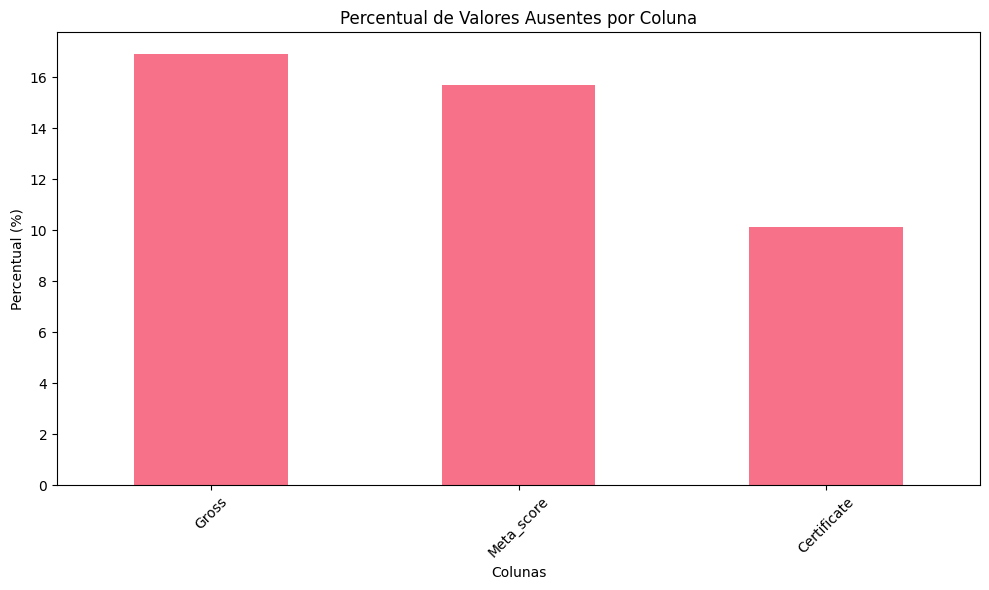

In [5]:
# Verificação de valores ausentes
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})

missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Valores ausentes por coluna:")
print(missing_data)

# Visualização dos valores ausentes
if not missing_data.empty:
    plt.figure(figsize=(10, 6))
    missing_data['Percentage'].plot(kind='bar')
    plt.title('Percentual de Valores Ausentes por Coluna')
    plt.ylabel('Percentual (%)')
    plt.xlabel('Colunas')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nNenhum valor ausente encontrado!")

## 4. Limpeza e Pré-processamento

In [6]:
# Funções de limpeza
def clean_runtime(runtime):
    if pd.isna(runtime):
        return np.nan
    return int(re.findall(r'\d+', str(runtime))[0])

def clean_gross(gross):
    if pd.isna(gross):
        return 0
    return int(str(gross).replace(',', '')) if str(gross).replace(',', '').isdigit() else 0

# Aplicar limpeza
print("Iniciando limpeza dos dados...")

# Limpeza da coluna Runtime
df['Runtime'] = df['Runtime'].apply(clean_runtime)

# Limpeza da coluna Gross
df['Gross'] = df['Gross'].apply(clean_gross)

# Imputação de valores ausentes em Meta_score com a média
df['Meta_score'].fillna(df['Meta_score'].mean(), inplace=True)

print("Limpeza concluída!")
print("\nDados após limpeza:")
df.info()

Iniciando limpeza dos dados...
Limpeza concluída!

Dados após limpeza:
<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     999 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          999 non-null    int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 124.9+ KB


## 5. Análise Exploratória de Dados (EDA)

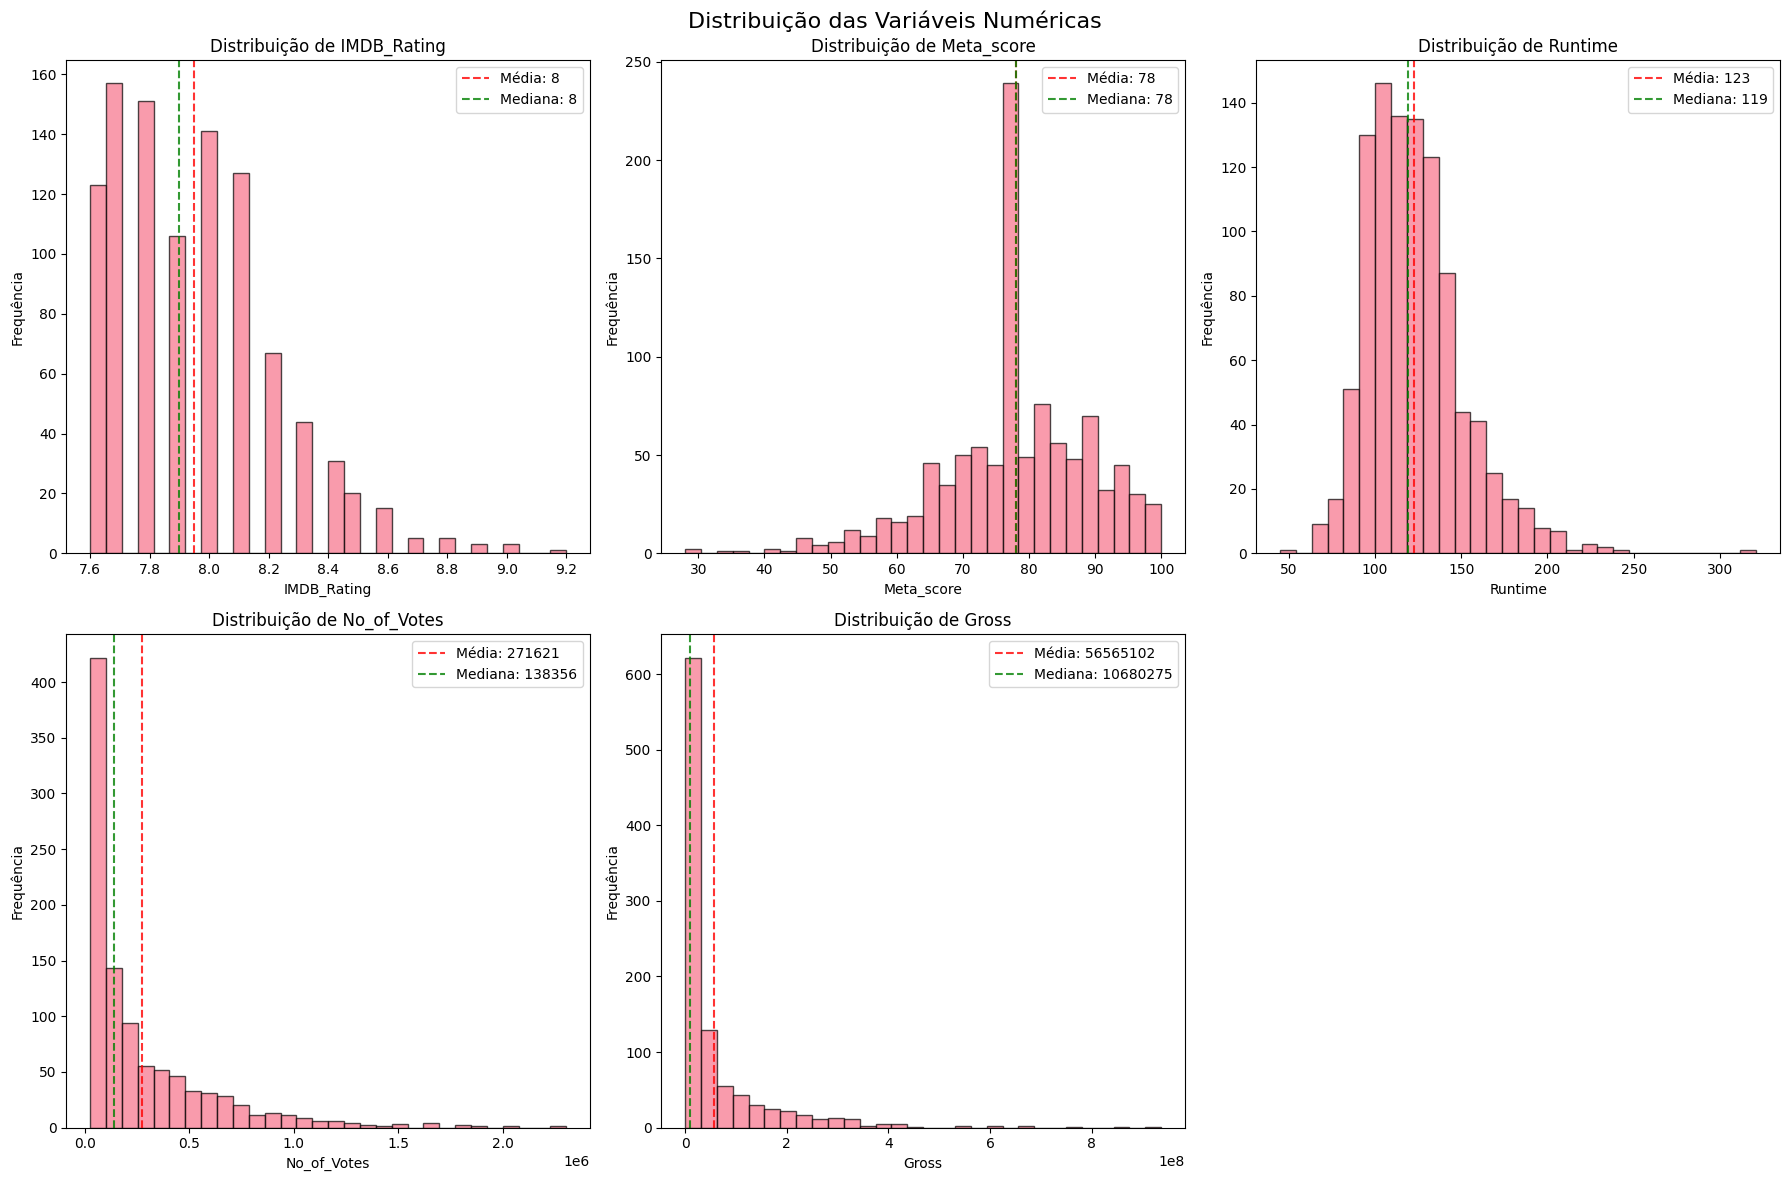

Estatísticas descritivas das variáveis numéricas:
       IMDB_Rating  Meta_score     Runtime   No_of_Votes         Gross
count   999.000000  999.000000  999.000000  9.990000e+02  9.990000e+02
mean      7.947948   77.969121  122.871872  2.716214e+05  5.656510e+07
std       0.272290   11.367570   28.101227  3.209126e+05  1.032860e+08
min       7.600000   28.000000   45.000000  2.508800e+04  0.000000e+00
25%       7.700000   72.000000  103.000000  5.547150e+04  4.422285e+05
50%       7.900000   77.969121  119.000000  1.383560e+05  1.068028e+07
75%       8.100000   85.500000  137.000000  3.731675e+05  6.157656e+07
max       9.200000  100.000000  321.000000  2.303232e+06  9.366622e+08


In [7]:
# Distribuição das principais variáveis numéricas
numerical_cols = ['IMDB_Rating', 'Meta_score', 'Runtime', 'No_of_Votes', 'Gross']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)

for i, col in enumerate(numerical_cols):
    row = i // 3
    col_idx = i % 3
    
    # Histograma
    axes[row, col_idx].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    axes[row, col_idx].set_title(f'Distribuição de {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequência')
    
    # Estatísticas básicas
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[row, col_idx].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Média: {mean_val:.0f}')
    axes[row, col_idx].axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Mediana: {median_val:.0f}')
    axes[row, col_idx].legend()

# Remove o subplot extra
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# Estatísticas descritivas detalhadas
print("Estatísticas descritivas das variáveis numéricas:")
print(df[numerical_cols].describe())

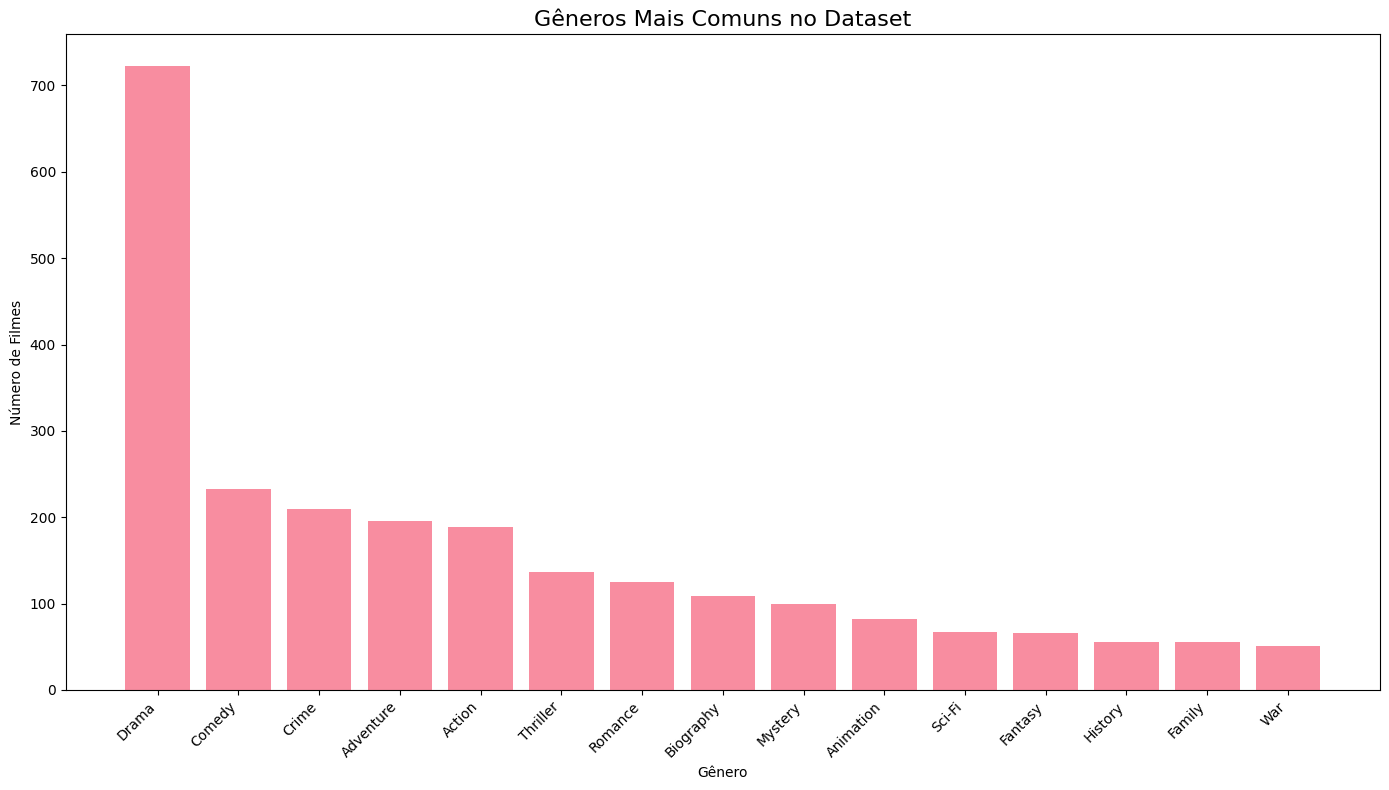

Total de gêneros únicos: 21

Top 10 gêneros mais comuns:
Drama: 723 filmes
Comedy: 233 filmes
Crime: 209 filmes
Adventure: 196 filmes
Action: 189 filmes
Thriller: 137 filmes
Romance: 125 filmes
Biography: 109 filmes
Mystery: 99 filmes
Animation: 82 filmes


In [8]:
# Análise dos gêneros
all_genres = []
for genres in df['Genre'].dropna():
    genre_list = [genre.strip() for genre in genres.split(',')]
    all_genres.extend(genre_list)

genre_counts = Counter(all_genres)
top_genres = dict(genre_counts.most_common(15))

# Visualização dos gêneros mais comuns
plt.figure(figsize=(14, 8))
plt.bar(top_genres.keys(), top_genres.values(), alpha=0.8)
plt.title('Gêneros Mais Comuns no Dataset', fontsize=16)
plt.xlabel('Gênero')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Total de gêneros únicos: {len(genre_counts)}")
print("\nTop 10 gêneros mais comuns:")
for genre, count in genre_counts.most_common(10):
    print(f"{genre}: {count} filmes")

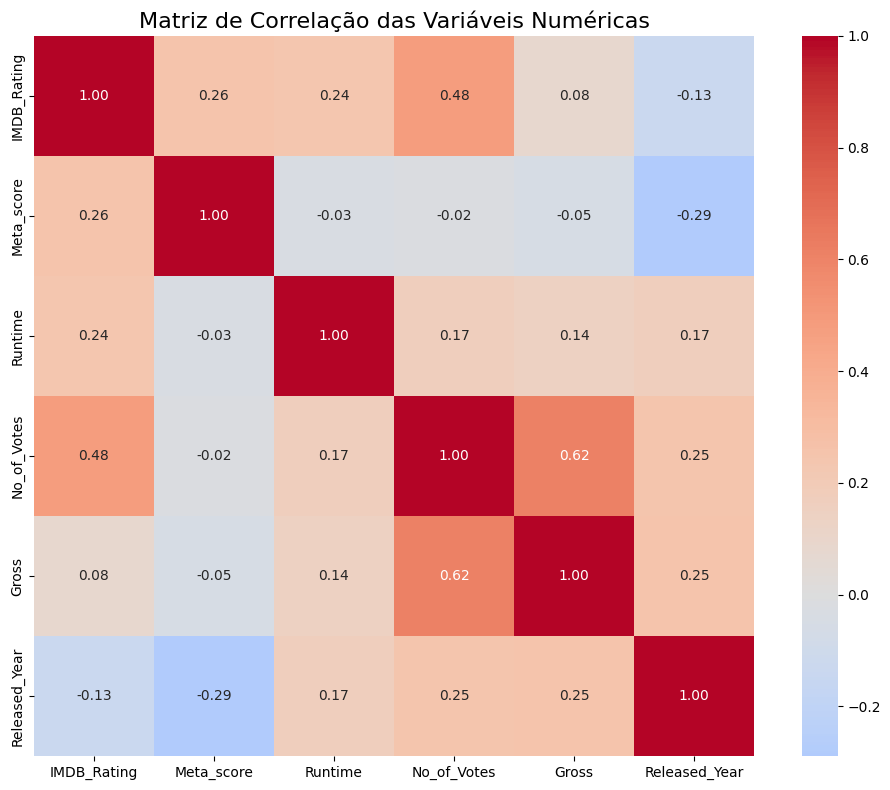

Principais correlações com IMDB_Rating:
No_of_Votes: 0.479
Meta_score: 0.256
Runtime: 0.243
Released_Year: -0.133
Gross: 0.085


In [9]:
# Matriz de correlação
correlation_vars = ['IMDB_Rating', 'Meta_score', 'Runtime', 'No_of_Votes', 'Gross']
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
correlation_vars.append('Released_Year')

correlation_matrix = df[correlation_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

# Principais correlações
print("Principais correlações com IMDB_Rating:")
imdb_corr = correlation_matrix['IMDB_Rating'].abs().sort_values(ascending=False)
for var, corr in imdb_corr.items():
    if var != 'IMDB_Rating':
        print(f"{var}: {correlation_matrix['IMDB_Rating'][var]:.3f}")

## 6. Questões de Negócio

### 6.1. Qual filme recomendaria para uma pessoa desconhecida?

In [10]:
# Implementação da fórmula de weighted rating (similar ao IMDB Top 250)
def calculate_weighted_rating(df, rating_col='IMDB_Rating', votes_col='No_of_Votes'):
    """
    Calcula o weighted rating usando a fórmula do IMDB:
    WR = (v/(v+m)) * R + (m/(v+m)) * C
    """
    C = df[rating_col].mean()
    m = df[votes_col].quantile(0.90)
    
    df['weighted_rating'] = ((df[votes_col] / (df[votes_col] + m)) * df[rating_col] + 
                            (m / (df[votes_col] + m)) * C)
    
    return df

# Calcular weighted rating
df_weighted = calculate_weighted_rating(df.copy())

# Top 10 filmes por weighted rating
top_movies = df_weighted.nlargest(10, 'weighted_rating')[[
    'Series_Title', 'Released_Year', 'IMDB_Rating', 'No_of_Votes', 'weighted_rating', 'Genre'
]].round(3)

print("TOP 10 FILMES PARA RECOMENDAÇÃO UNIVERSAL:")
print("="*60)
for idx, (_, movie) in enumerate(top_movies.iterrows(), 1):
    print(f"{idx}. {movie['Series_Title']} ({movie['Released_Year']})")
    print(f"   Rating: {movie['IMDB_Rating']} | Votos: {movie['No_of_Votes']:,} | Weighted: {movie['weighted_rating']:.3f}")
    print(f"   Gênero: {movie['Genre']}")
    print()

recommendation = top_movies.iloc[0]
print(f"RECOMENDAÇÃO FINAL: {recommendation['Series_Title']}")
print(f"Justificativa: Este filme combina excelência crítica (Rating {recommendation['IMDB_Rating']}) ")
print(f"com amplo apelo popular ({recommendation['No_of_Votes']:,} votos).")

TOP 10 FILMES PARA RECOMENDAÇÃO UNIVERSAL:
1. The Godfather (1972.0)
   Rating: 9.2 | Votos: 1,620,367 | Weighted: 8.824
   Gênero: Crime, Drama

2. The Dark Knight (2008.0)
   Rating: 9.0 | Votos: 2,303,232 | Weighted: 8.756
   Gênero: Action, Crime, Drama

3. Pulp Fiction (1994.0)
   Rating: 8.9 | Votos: 1,826,188 | Weighted: 8.638
   Gênero: Crime, Drama

4. The Lord of the Rings: The Return of the King (2003.0)
   Rating: 8.9 | Votos: 1,642,758 | Weighted: 8.617
   Gênero: Action, Adventure, Drama

5. The Godfather: Part II (1974.0)
   Rating: 9.0 | Votos: 1,129,952 | Weighted: 8.599
   Gênero: Crime, Drama

6. Inception (2010.0)
   Rating: 8.8 | Votos: 2,067,042 | Weighted: 8.586
   Gênero: Action, Adventure, Sci-Fi

7. Fight Club (1999.0)
   Rating: 8.8 | Votos: 1,854,740 | Weighted: 8.568
   Gênero: Drama

8. Forrest Gump (1994.0)
   Rating: 8.8 | Votos: 1,809,221 | Weighted: 8.564
   Gênero: Drama, Romance

9. Schindler's List (1993.0)
   Rating: 8.9 | Votos: 1,213,505 | Weight

### 6.2. Principais fatores relacionados com alto faturamento

In [11]:
# Análise dos fatores de alto faturamento
def extract_primary_genre(genre_string):
    if pd.isna(genre_string):
        return 'Unknown'
    return genre_string.split(',')[0].strip()

df['Primary_Genre'] = df['Genre'].apply(extract_primary_genre)
high_grossing = df[df['Gross'] > df['Gross'].quantile(0.75)]  # Top 25% em faturamento

print("ANÁLISE DOS FATORES DE ALTO FATURAMENTO")
print("="*50)
print(f"Filmes analisados: {len(high_grossing)} (top 25% em faturamento)")
print(f"Faturamento mínimo do grupo: ${high_grossing['Gross'].min():,}")
print(f"Faturamento médio do grupo: ${high_grossing['Gross'].mean():,.0f}")

# Análise por gênero nos filmes de alto faturamento
print("\n1. GÊNEROS MAIS LUCRATIVOS:")
high_gross_genres = high_grossing['Primary_Genre'].value_counts().head(10)
for genre, count in high_gross_genres.items():
    percentage = (count / len(high_grossing)) * 100
    avg_gross = high_grossing[high_grossing['Primary_Genre'] == genre]['Gross'].mean()
    print(f"   {genre}: {count} filmes ({percentage:.1f}%) - Média: ${avg_gross:,.0f}")

ANÁLISE DOS FATORES DE ALTO FATURAMENTO
Filmes analisados: 250 (top 25% em faturamento)
Faturamento mínimo do grupo: $61,649,911
Faturamento médio do grupo: $189,179,044

1. GÊNEROS MAIS LUCRATIVOS:
   Action: 73 filmes (29.2%) - Média: $254,388,713
   Drama: 48 filmes (19.2%) - Média: $142,925,315
   Animation: 34 filmes (13.6%) - Média: $244,053,552
   Biography: 28 filmes (11.2%) - Média: $119,512,258
   Adventure: 23 filmes (9.2%) - Média: $192,701,196
   Crime: 19 filmes (7.6%) - Média: $113,023,513
   Comedy: 19 filmes (7.6%) - Média: $131,196,761
   Horror: 4 filmes (1.6%) - Média: $146,092,374
   Mystery: 1 filmes (0.4%) - Média: $128,012,934
   Family: 1 filmes (0.4%) - Média: $435,110,554


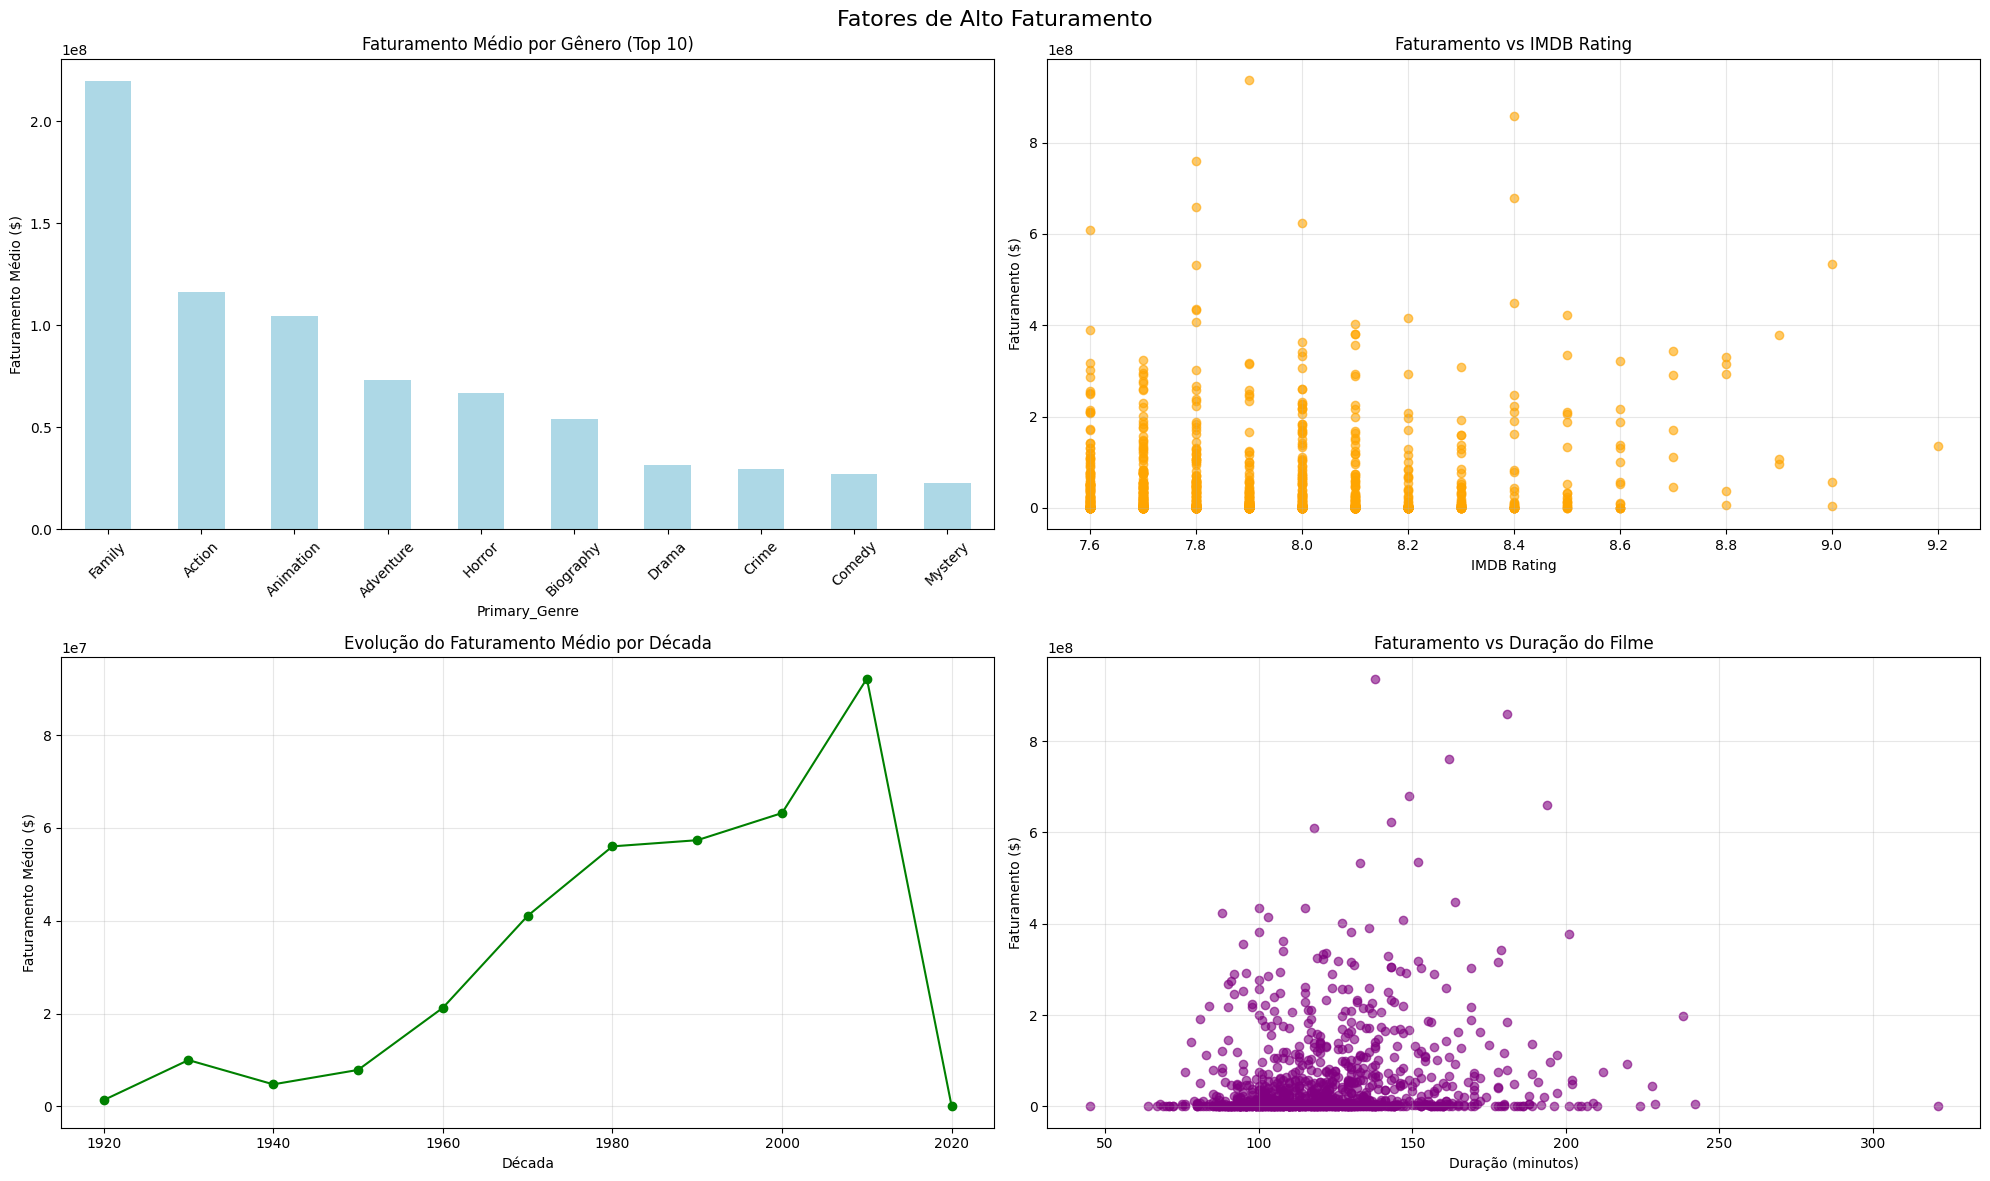

In [12]:
# Visualização dos fatores de faturamento
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Fatores de Alto Faturamento', fontsize=16)

# Gêneros vs Faturamento
genre_gross = df.groupby('Primary_Genre')['Gross'].mean().sort_values(ascending=False).head(10)
genre_gross.plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Faturamento Médio por Gênero (Top 10)')
axes[0,0].set_ylabel('Faturamento Médio ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Faturamento vs Rating
axes[0,1].scatter(df['IMDB_Rating'], df['Gross'], alpha=0.6, color='orange')
axes[0,1].set_xlabel('IMDB Rating')
axes[0,1].set_ylabel('Faturamento ($)')
axes[0,1].set_title('Faturamento vs IMDB Rating')
axes[0,1].grid(True, alpha=0.3)

# Faturamento por década
df['Decade'] = (df['Released_Year'] // 10) * 10
decade_gross = df.groupby('Decade')['Gross'].mean()
decade_gross.plot(kind='line', ax=axes[1,0], marker='o', color='green')
axes[1,0].set_title('Evolução do Faturamento Médio por Década')
axes[1,0].set_xlabel('Década')
axes[1,0].set_ylabel('Faturamento Médio ($)')
axes[1,0].grid(True, alpha=0.3)

# Duração vs Faturamento
axes[1,1].scatter(df['Runtime'], df['Gross'], alpha=0.6, color='purple')
axes[1,1].set_xlabel('Duração (minutos)')
axes[1,1].set_ylabel('Faturamento ($)')
axes[1,1].set_title('Faturamento vs Duração do Filme')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.3. Insights da coluna Overview e predição de gênero

In [13]:
# Análise textual da coluna Overview
print("ANÁLISE DA COLUNA OVERVIEW")
print("="*30)

# Estatísticas básicas do texto
df['overview_length'] = df['Overview'].str.len()
df['overview_words'] = df['Overview'].str.split().str.len()

print(f"Comprimento médio das sinopses: {df['overview_length'].mean():.1f} caracteres")
print(f"Número médio de palavras: {df['overview_words'].mean():.1f} palavras")
print(f"Sinopse mais longa: {df['overview_length'].max()} caracteres")
print(f"Sinopse mais curta: {df['overview_length'].min()} caracteres")

# Função para pré-processar texto
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Converter para minúsculas
    text = text.lower()
    
    # Remover pontuação e caracteres especiais
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenizar
    tokens = word_tokenize(text)
    
    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

# Pré-processar todas as sinopses
df['processed_overview'] = df['Overview'].apply(preprocess_text)

print("\nPré-processamento de texto concluído!")

ANÁLISE DA COLUNA OVERVIEW
Comprimento médio das sinopses: 146.3 caracteres
Número médio de palavras: 25.0 palavras
Sinopse mais longa: 313 caracteres
Sinopse mais curta: 40 caracteres

Pré-processamento de texto concluído!


PALAVRAS MAIS COMUNS NAS SINOPSES:
young: 132
man: 110
two: 103
life: 101
world: 78
new: 72
story: 63
war: 61
love: 61
woman: 60
family: 59
one: 57
find: 54
must: 50
finds: 47
help: 45
becomes: 44
boy: 42
friends: 41
girl: 39


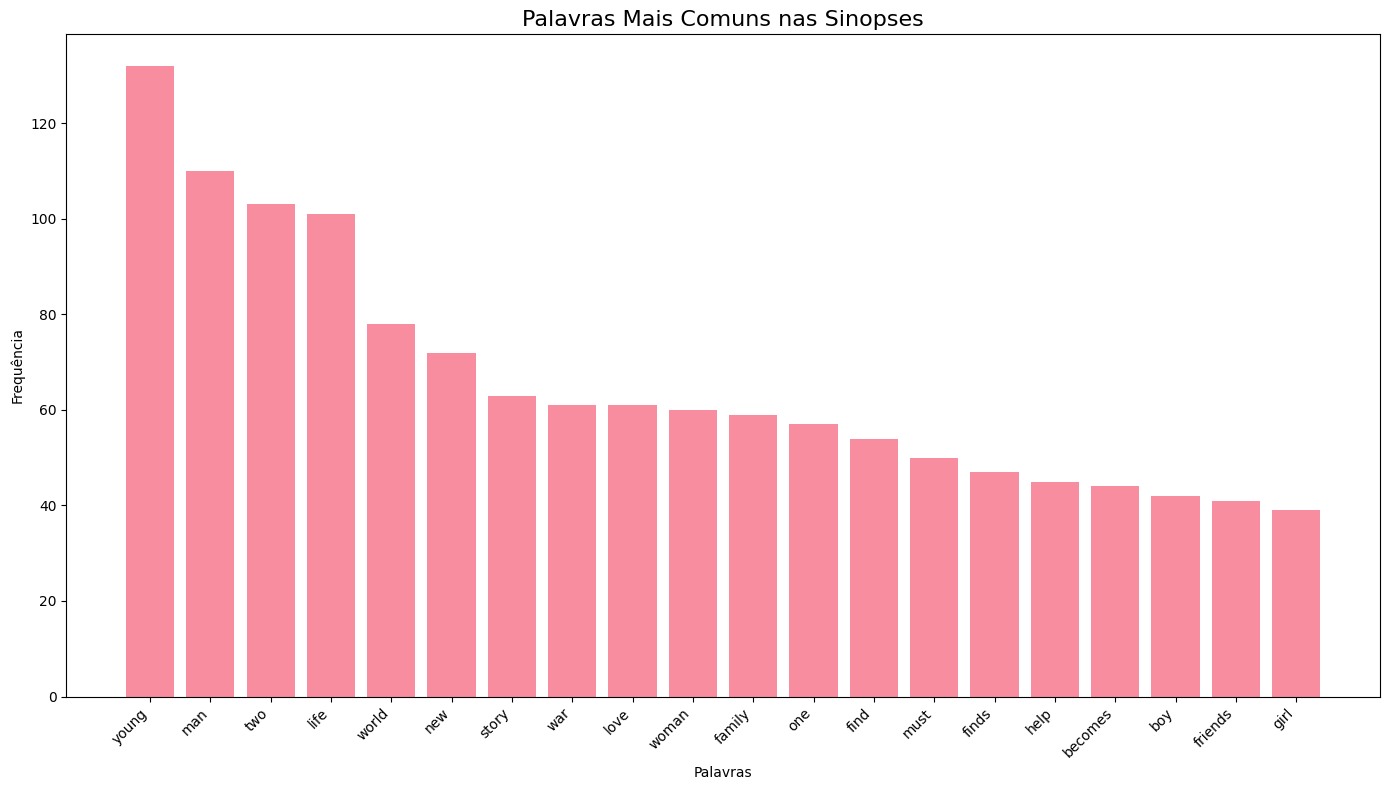

In [14]:
# Análise das palavras mais comuns
all_words = []
for overview in df['processed_overview'].dropna():
    words = overview.split()
    all_words.extend(words)

word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

print("PALAVRAS MAIS COMUNS NAS SINOPSES:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Visualização das palavras mais comuns
words, counts = zip(*most_common_words)

plt.figure(figsize=(14, 8))
plt.bar(words, counts, alpha=0.8)
plt.title('Palavras Mais Comuns nas Sinopses', fontsize=16)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Modelo de Predição da Nota IMDB

In [15]:
# Engenharia de features
print("ENGENHARIA DE FEATURES PARA PREDIÇÃO DA NOTA IMDB")
print("="*55)

df_model = df.copy()

# 1. Features básicas numéricas
basic_features = ['Meta_score', 'Runtime', 'No_of_Votes', 'Gross', 'Released_Year']

# 2. One-hot encoding para gêneros
print("Criando features de gênero...")
top_genres_list = [genre for genre, count in Counter(all_genres).most_common(10)]

for genre in top_genres_list:
    df_model[f'Genre_{genre}'] = df_model['Genre'].str.contains(genre, na=False).astype(int)

genre_features = [f'Genre_{genre}' for genre in top_genres_list]

# 3. Features baseadas no histórico do diretor
print("Criando features do diretor...")
director_avg_rating = df_model.groupby('Director')['IMDB_Rating'].transform('mean')
director_movie_count = df_model.groupby('Director')['Series_Title'].transform('count')

df_model['director_avg_rating'] = director_avg_rating
df_model['director_movie_count'] = director_movie_count

# 4. Features baseadas no ator principal
print("Criando features do ator principal...")
star1_avg_rating = df_model.groupby('Star1')['IMDB_Rating'].transform('mean')
star1_movie_count = df_model.groupby('Star1')['Series_Title'].transform('count')

df_model['star1_avg_rating'] = star1_avg_rating
df_model['star1_movie_count'] = star1_movie_count

# 5. Features derivadas
print("Criando features derivadas...")
df_model['votes_per_year'] = df_model['No_of_Votes'] / (2024 - df_model['Released_Year'] + 1)
df_model['gross_per_vote'] = df_model['Gross'] / (df_model['No_of_Votes'] + 1)
df_model['is_long_movie'] = (df_model['Runtime'] > 120).astype(int)
df_model['is_recent'] = (df_model['Released_Year'] >= 2000).astype(int)

# Lista completa de features
feature_columns = (basic_features + genre_features + 
                  ['director_avg_rating', 'director_movie_count',
                   'star1_avg_rating', 'star1_movie_count',
                   'votes_per_year', 'gross_per_vote', 'is_long_movie', 'is_recent'])

print(f"\nTotal de features criadas: {len(feature_columns)}")
print("Features principais:")
for i, feature in enumerate(feature_columns[:10], 1):
    print(f"{i:2d}. {feature}")

ENGENHARIA DE FEATURES PARA PREDIÇÃO DA NOTA IMDB
Criando features de gênero...
Criando features do diretor...
Criando features do ator principal...
Criando features derivadas...

Total de features criadas: 23
Features principais:
 1. Meta_score
 2. Runtime
 3. No_of_Votes
 4. Gross
 5. Released_Year
 6. Genre_Drama
 7. Genre_Comedy
 8. Genre_Crime
 9. Genre_Adventure
10. Genre_Action


In [16]:
# Preparar dados para modelagem
df_clean_model = df_model.dropna(subset=feature_columns + ['IMDB_Rating']).copy()

X = df_clean_model[feature_columns]
y = df_clean_model['IMDB_Rating']

print(f"Dataset para modelagem: {X.shape[0]} filmes, {X.shape[1]} features")
print(f"Target (IMDB_Rating): min={y.min():.2f}, max={y.max():.2f}, média={y.mean():.2f}")

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

Dataset para modelagem: 998 filmes, 23 features
Target (IMDB_Rating): min=7.60, max=9.20, média=7.95

Dados de treino: (798, 23)
Dados de teste: (200, 23)


In [17]:
# Treinamento e comparação de modelos
model_results = {}

# 1. Regressão Linear
print("1. Treinando Regressão Linear...")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

model_results['Linear Regression'] = {
    'model': lr,
    'predictions': lr_pred,
    'rmse': lr_rmse,
    'r2': lr_r2
}

print(f"RMSE: {lr_rmse:.3f}")
print(f"R²: {lr_r2:.3f}")

# 2. Random Forest
print("\n2. Treinando Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

model_results['Random Forest'] = {
    'model': rf,
    'predictions': rf_pred,
    'rmse': rf_rmse,
    'r2': rf_r2
}

print(f"RMSE: {rf_rmse:.3f}")
print(f"R²: {rf_r2:.3f}")

# 3. LightGBM
print("\n3. Treinando LightGBM...")
lgbm = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=-1
)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
lgbm_r2 = r2_score(y_test, lgbm_pred)

model_results['LightGBM'] = {
    'model': lgbm,
    'predictions': lgbm_pred,
    'rmse': lgbm_rmse,
    'r2': lgbm_r2
}

print(f"RMSE: {lgbm_rmse:.3f}")
print(f"R²: {lgbm_r2:.3f}")

# Resumo da comparação
print("\n" + "="*60)
print("RESUMO DA COMPARAÇÃO DE MODELOS")
print("="*60)

comparison_df = pd.DataFrame({
    'Modelo': list(model_results.keys()),
    'RMSE': [result['rmse'] for result in model_results.values()],
    'R²': [result['r2'] for result in model_results.values()]
}).round(3)

comparison_df = comparison_df.sort_values('RMSE')
print(comparison_df)

# Melhor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_model = model_results[best_model_name]['model']
print(f"\nMELHOR MODELO: {best_model_name}")
print(f"RMSE: {model_results[best_model_name]['rmse']:.3f}")
print(f"R²: {model_results[best_model_name]['r2']:.3f}")

1. Treinando Regressão Linear...
RMSE: 0.125
R²: 0.764

2. Treinando Random Forest...
RMSE: 0.116
R²: 0.794

3. Treinando LightGBM...
RMSE: 0.110
R²: 0.817

RESUMO DA COMPARAÇÃO DE MODELOS
              Modelo   RMSE     R²
2           LightGBM  0.110  0.817
1      Random Forest  0.116  0.794
0  Linear Regression  0.125  0.764

MELHOR MODELO: LightGBM
RMSE: 0.110
R²: 0.817


## 8. Predição para The Shawshank Redemption

In [18]:
# Dados do filme solicitado
shawshank_data = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': 142,
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': 28341469
}

print("PREDIÇÃO PARA 'THE SHAWSHANK REDEMPTION'")
print("="*45)

# Criar DataFrame com os dados
shawshank_df = pd.DataFrame([shawshank_data])

# Processar da mesma forma que os dados de treino
def create_features_for_prediction(df_input, df_reference):
    """Criar features para predição baseado no dataset de referência"""
    df_pred = df_input.copy()
    
    # One-hot encoding para gêneros
    for genre in top_genres_list:
        df_pred[f'Genre_{genre}'] = df_pred['Genre'].str.contains(genre, na=False).astype(int)
    
    # Features do diretor (baseado no dataset histórico)
    director_stats = df_reference.groupby('Director')['IMDB_Rating'].agg(['mean', 'count'])
    director = df_pred['Director'].iloc[0]
    if director in director_stats.index:
        df_pred['director_avg_rating'] = director_stats.loc[director, 'mean']
        df_pred['director_movie_count'] = director_stats.loc[director, 'count']
    else:
        df_pred['director_avg_rating'] = df_reference['IMDB_Rating'].mean()
        df_pred['director_movie_count'] = 1
    
    # Features do ator principal
    star1_stats = df_reference.groupby('Star1')['IMDB_Rating'].agg(['mean', 'count'])
    star1 = df_pred['Star1'].iloc[0]
    if star1 in star1_stats.index:
        df_pred['star1_avg_rating'] = star1_stats.loc[star1, 'mean']
        df_pred['star1_movie_count'] = star1_stats.loc[star1, 'count']
    else:
        df_pred['star1_avg_rating'] = df_reference['IMDB_Rating'].mean()
        df_pred['star1_movie_count'] = 1
    
    # Features derivadas
    df_pred['votes_per_year'] = df_pred['No_of_Votes'] / (2024 - df_pred['Released_Year'] + 1)
    df_pred['gross_per_vote'] = df_pred['Gross'] / (df_pred['No_of_Votes'] + 1)
    df_pred['is_long_movie'] = (df_pred['Runtime'] > 120).astype(int)
    df_pred['is_recent'] = (df_pred['Released_Year'] >= 2000).astype(int)
    
    return df_pred

# Criar features
shawshank_processed = create_features_for_prediction(shawshank_df, df_model)

# Extrair apenas as features necessárias
X_shawshank = shawshank_processed[feature_columns]

# Fazer predições com todos os modelos
print("PREDIÇÕES:")
print("-" * 20)

for model_name, results in model_results.items():
    model = results['model']
    prediction = model.predict(X_shawshank)[0]
    print(f"{model_name}: {prediction:.3f}")

# Predição do melhor modelo
best_prediction = best_model.predict(X_shawshank)[0]
print(f"\nPREDIÇÃO FINAL ({best_model_name}): {best_prediction:.3f}")

# Comparação com o valor real (se conhecido)
real_shawshank = df[df['Series_Title'] == 'The Shawshank Redemption']
if not real_shawshank.empty:
    real_rating = real_shawshank['IMDB_Rating'].iloc[0]
    error = abs(best_prediction - real_rating)
    print(f"RATING REAL: {real_rating}")
    print(f"ERRO ABSOLUTO: {error:.3f}")
    print(f"PRECISÃO: {(1 - error/real_rating)*100:.1f}%")
else:
    print("Valor real não encontrado no dataset para comparação.")

PREDIÇÃO PARA 'THE SHAWSHANK REDEMPTION'
PREDIÇÕES:
--------------------
Linear Regression: 8.904
Random Forest: 8.414
LightGBM: 8.484

PREDIÇÃO FINAL (LightGBM): 8.484
Valor real não encontrado no dataset para comparação.


## 9. Salvando o Modelo

In [19]:
# Salvar o melhor modelo e componentes necessários
model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'feature_columns': feature_columns,
    'top_genres': top_genres_list,
    'performance': {
        'rmse': model_results[best_model_name]['rmse'],
        'r2': model_results[best_model_name]['r2']
    },
    'training_stats': {
        'director_avg_rating': df_model.groupby('Director')['IMDB_Rating'].mean().to_dict(),
        'star1_avg_rating': df_model.groupby('Star1')['IMDB_Rating'].mean().to_dict(),
        'director_movie_count': df_model.groupby('Director')['Series_Title'].count().to_dict(),
        'star1_movie_count': df_model.groupby('Star1')['Series_Title'].count().to_dict(),
        'imdb_rating_mean': df_model['IMDB_Rating'].mean()
    },
    'version': '1.0',
    'created_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Salvar o modelo
with open('modelo_imdb.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("MODELO SALVO COM SUCESSO!")
print("="*30)
print(f"Arquivo: modelo_imdb.pkl")
print(f"Modelo: {best_model_name}")
print(f"Performance: RMSE={model_results[best_model_name]['rmse']:.3f}, R²={model_results[best_model_name]['r2']:.3f}")
print(f"Features: {len(feature_columns)}")
print(f"Data: {model_package['created_date']}")

# Testar carregamento do modelo
print("\nTestando carregamento do modelo...")
with open('modelo_imdb.pkl', 'rb') as f:
    loaded_model_package = pickle.load(f)

# Teste de predição com modelo carregado
loaded_model = loaded_model_package['model']
test_prediction = loaded_model.predict(X_shawshank)[0]
print(f"Modelo carregado com sucesso!")
print(f"Teste de predição: {test_prediction:.3f}")
print(f"Componentes incluídos: {list(loaded_model_package.keys())}")

MODELO SALVO COM SUCESSO!
Arquivo: modelo_imdb.pkl
Modelo: LightGBM
Performance: RMSE=0.110, R²=0.817
Features: 23
Data: 2025-09-07 21:46:23

Testando carregamento do modelo...
Modelo carregado com sucesso!
Teste de predição: 8.484
Componentes incluídos: ['model', 'model_name', 'feature_columns', 'top_genres', 'performance', 'training_stats', 'version', 'created_date']


## 10. Conclusões e Recomendações Estratégicas

In [20]:
print("CONCLUSÕES E RECOMENDAÇÕES ESTRATÉGICAS PARA PPRODUCTIONS")
print("="*65)

print("\n1. RECOMENDAÇÃO UNIVERSAL:")
print(f"   Para um público desconhecido, recomendamos '{recommendation['Series_Title']}'.")
print(f"   Este filme combina excelência crítica com amplo apelo popular.")

print("\n2. FATORES DE SUCESSO FINANCEIRO:")
top_commercial_genres = df.groupby('Primary_Genre')['Gross'].mean().sort_values(ascending=False).head(3)
print("   Gêneros mais lucrativos:")
for genre, avg_gross in top_commercial_genres.items():
    print(f"   • {genre}: ${avg_gross:,.0f} médio")

print("\n3. FATORES DE ACLAMAÇÃO CRÍTICA:")
if best_model_name in ['Random Forest', 'LightGBM']:
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("   Principais preditores de alta nota IMDB:")
    for idx, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
        print(f"   {idx}. {row['feature']} (importância: {row['importance']:.3f})")

print(f"\n4. MODELO PREDITIVO:")
print(f"   • Melhor algoritmo: {best_model_name}")
print(f"   • Precisão: RMSE = {model_results[best_model_name]['rmse']:.3f}, R² = {model_results[best_model_name]['r2']:.3f}")
print(f"   • O modelo explica {model_results[best_model_name]['r2']*100:.1f}% da variância nas notas IMDB")

print("\nESTRATÉGIA RECOMENDADA PARA PPRODUCTIONS:")
print("   1. Para SUCESSO COMERCIAL: Foque em Action/Adventure/Animation")
print("   2. Para PRESTÍGIO: Priorize Drama com diretores renomados")
print("   3. SWEET SPOT: Filmes de conceito elevado que equilibram espetáculo e substância")
print("   4. FATORES CRÍTICOS: Meta_score (críticos), popularidade (votos) e histórico da equipe")

print("\n" + "="*65)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("Todos os entregáveis foram criados:")
print("- Análise Exploratória de Dados (EDA)")
print("- Respostas às questões de negócio")
print("- Modelo de predição de rating IMDB")
print("- Predição para The Shawshank Redemption")
print("- Modelo salvo em formato .pkl")
print("="*65)

CONCLUSÕES E RECOMENDAÇÕES ESTRATÉGICAS PARA PPRODUCTIONS

1. RECOMENDAÇÃO UNIVERSAL:
   Para um público desconhecido, recomendamos 'The Godfather'.
   Este filme combina excelência crítica com amplo apelo popular.

2. FATORES DE SUCESSO FINANCEIRO:
   Gêneros mais lucrativos:
   • Family: $219,555,277 médio
   • Action: $116,376,721 médio
   • Animation: $104,558,834 médio

3. FATORES DE ACLAMAÇÃO CRÍTICA:
   Principais preditores de alta nota IMDB:
   1. No_of_Votes (importância: 385.000)
   2. star1_avg_rating (importância: 269.000)
   3. director_avg_rating (importância: 255.000)
   4. votes_per_year (importância: 252.000)
   5. Runtime (importância: 249.000)

4. MODELO PREDITIVO:
   • Melhor algoritmo: LightGBM
   • Precisão: RMSE = 0.110, R² = 0.817
   • O modelo explica 81.7% da variância nas notas IMDB

ESTRATÉGIA RECOMENDADA PARA PPRODUCTIONS:
   1. Para SUCESSO COMERCIAL: Foque em Action/Adventure/Animation
   2. Para PRESTÍGIO: Priorize Drama com diretores renomados
   3. SW